In [1]:
import torch
from src.datasets.base_dataset import dataset_globber
from src.datasets.patch_dataset import PatchMaskDataset
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

config: dict[str, int | str | list | float] = {
    "batch_size": 1,
    "target_level": 3,
    "num_workers": 9,
    'seed':42,
    "base_dir": "/data2/projects/DigiStrudMed_sklein/",
    "data_split": [0.8, 0.15, 0.05],
    "annos_of_interest": [
        "Tissue",
        "Tumor_vital",
        "Angioinvasion",
        "Tumor_necrosis",
        "Tumor_regression",
    ],
}

level: int = int(config["target_level"])
config["cache_path"] = (
    config["base_dir"]
    + f"downsampled_datasets/cached_DownsampleDataset_level_{level}.json"
)

input_dicts = dataset_globber(
    config["base_dir"] + "DigiStrucMed_Braesen/all_data/",
    config["base_dir"] + "survival_status.csv",
)
img_transform = transforms.Compose(
    [
        # transforms.ColorJitter(
        #     brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01
        # ),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

    ]
)

stack_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
    ]
)

dataset = PatchMaskDataset(
    data = input_dicts[:3],
    keys=config['annos_of_interest'],
    foreground_key=config['annos_of_interest'][0],
    image_key="image",
    censor_key="uncensored",
    label_key="surv_days",
    json_key="geojson",
    transform1=img_transform,
    transform2=stack_transform,
)

Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C.svs
Added 26868 patches! Time elapsed: 0.8254368305206299
Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.016~B.svs
Added 26844 patches! Time elapsed: 1.0706455707550049
Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.019~E.svs
Added 26704 patches! Time elapsed: 1.3553495407104492


In [2]:
dataset[0]['data']

INFO:Timer:Loading image and masks 6.9141387939453125e-06
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
INFO:Timer:Loading done 0.009306669235229492
INFO:Timer:Starting patch extraction for masks 0.009853839874267578
INFO:Timer:Size of image patch [512, 512, 3] 0.08712315559387207
INFO:Timer:Patch extraction for image done 0.08783650398254395
INFO:Timer:Starting conversion to tensor 0.08807063102722168
INFO:Timer:Converting masks to numpy done 0.08833432197570801
INFO:Timer:Converting to tensor done 0.11338996887207031
INFO:Timer:Starting padding 0.1137242317199707
INFO:Timer:Padding done 0.11406254768371582
INFO:Timer:R

tensor([[[1.4783, 1.4783, 1.5125,  ..., 0.0000, 0.0000, 0.0000],
         [1.4783, 1.4783, 1.5125,  ..., 0.0000, 0.0000, 0.0000],
         [1.4612, 1.4954, 1.5297,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.3755, 1.3927, 1.4269,  ..., 0.0000, 0.0000, 0.0000],
         [1.3584, 1.3927, 1.4098,  ..., 0.0000, 0.0000, 0.0000],
         [1.3584, 1.3927, 1.4098,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.3081, 1.3081, 1.3256,  ..., 0.0000, 0.0000, 0.0000],
         [1.3081, 1.3081, 1.3081,  ..., 0.0000, 0.0000, 0.0000],
         [1.2906, 1.3256, 1.3256,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.1681, 1.1856, 1.1681,  ..., 0.0000, 0.0000, 0.0000],
         [1.1681, 1.1856, 1.1681,  ..., 0.0000, 0.0000, 0.0000],
         [1.1681, 1.1856, 1.1856,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.8557, 1.8557, 1.8383,  ..., 0.0000, 0.0000, 0.0000],
         [1.8383, 1.8383, 1.8208,  ..., 0.0000, 0.0000, 0.0000],
         [1.8383, 1.8208, 1.8208,  ..., 0.0000, 0.0000, 0.

In [3]:
import re
from typing import Any

def _get_ids(x: str) -> list[str]:
    filename = re.findall(r"([^/]*$)", x)
    print(filename)
    if filename is not None:
        print(re.findall(r"(\d{3})(?:\.|\~|.)", filename[0]))
        return re.findall(r"(\d{3})(?:\.|\~|.)", filename[0])
    else:
        raise ValueError("Could not determine ids from filename")

# _get_ids: Callable = lambda x: re.findall(r"(?:\d{3})(?!RCC-TA-)", x)

def _get_case_id(sample: dict[str, Any]) -> int:
    # import pdb; pdb.set_trace()
    return int(_get_ids(sample['image']) [0])

def _get_stain_id(sample: dict[str, Any]) -> int:
    basename_parts = _get_ids(sample['image'])
    print(basename_parts)
    if len(basename_parts) == 3:
        return int(basename_parts[2])  # Haemalaun stain
    elif len(basename_parts) == 2:
        return int(basename_parts[1])  # all other stains
    else:
        raise ValueError(f"Could not determine stain id from filename {sample['image']}")

In [4]:
name = "/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-038.016flipped.svs"
_get_stain_id({'image':name})

['RCC-TA-038.016flipped.svs', '']
['038', '016']
['038', '016']


16

In [5]:
# plot the first image
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt
import torch
from matplotlib import colors
import matplotlib.legend_handler as lh
from matplotlib.lines import Line2D
import os
import matplotlib

def overlay_masks(sample, path=""):
    masks = torch.unbind(sample['data'][3:])
    tissue = masks[0]
    image = sample['data'][:3]
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    image = image * tissue
    img = (image * 255).type(torch.uint8)

    drawn_masks = []
    for mask in masks:
        mask = mask.type(torch.bool)
        drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))
    for mask in drawn_masks:
        mask[mask==0] = 255

    fig, axs = plt.subplots(1, len(drawn_masks), figsize=(20, 20))
    for i in range(0,len(drawn_masks)):
        axs[i].imshow(drawn_masks[i].permute(1, 2, 0))#, cmap="gray", vmin=0, vmax=1) # 
        plt.setp(axs[i].get_yticklabels(), visible=False)
    for ax in axs:
        ax.xaxis.tick_top()
    for ax, title in zip(axs, list(x.replace("_", " ") for x in config["annos_of_interest"])):
        ax.set_xlabel(title)
    fig.tight_layout()
    plt.show()

    # name=f"postproc_subimage_{sample['case_id']}-{sample['stain_id']}"
    # fig.savefig(path+name+".png", dpi=600, format='png', transparent=True)
    # fig.savefig(path+name+".svg", dpi=600, format='svg', transparent=True)

In [6]:
dataset[0]['data'].shape

INFO:Timer:Loading image and masks 4.291534423828125e-06
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
INFO:Timer:Loading done 0.0018880367279052734
INFO:Timer:Starting patch extraction for masks 0.002300739288330078
INFO:Timer:Size of image patch [512, 512, 3] 0.06211566925048828
INFO:Timer:Patch extraction for image done 0.06258773803710938
INFO:Timer:Starting conversion to tensor 0.06284093856811523
INFO:Timer:Converting masks to numpy done 0.06307244300842285
INFO:Timer:Converting to tensor done 0.06493020057678223
INFO:Timer:Starting padding 0.06524157524108887
INFO:Timer:Padding done 0.06554436683654785
INFO:Timer:

torch.Size([8, 512, 512])

INFO:Timer:Loading image and masks 5.4836273193359375e-06
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
INFO:Timer:Loading done 0.0021944046020507812
INFO:Timer:Starting patch extraction for masks 0.0026857852935791016
INFO:Timer:Size of image patch [512, 512, 3] 0.0739743709564209
INFO:Timer:Patch extraction for image done 0.07434272766113281
INFO:Timer:Starting conversion to tensor 0.07467126846313477
INFO:Timer:Converting masks to numpy done 0.0749824047088623
INFO:Timer:Converting to tensor done 0.07694125175476074
INFO:Timer:Starting padding 0.07724332809448242
INFO:Timer:Padding done 0.07755136489868164
INFO:Timer:

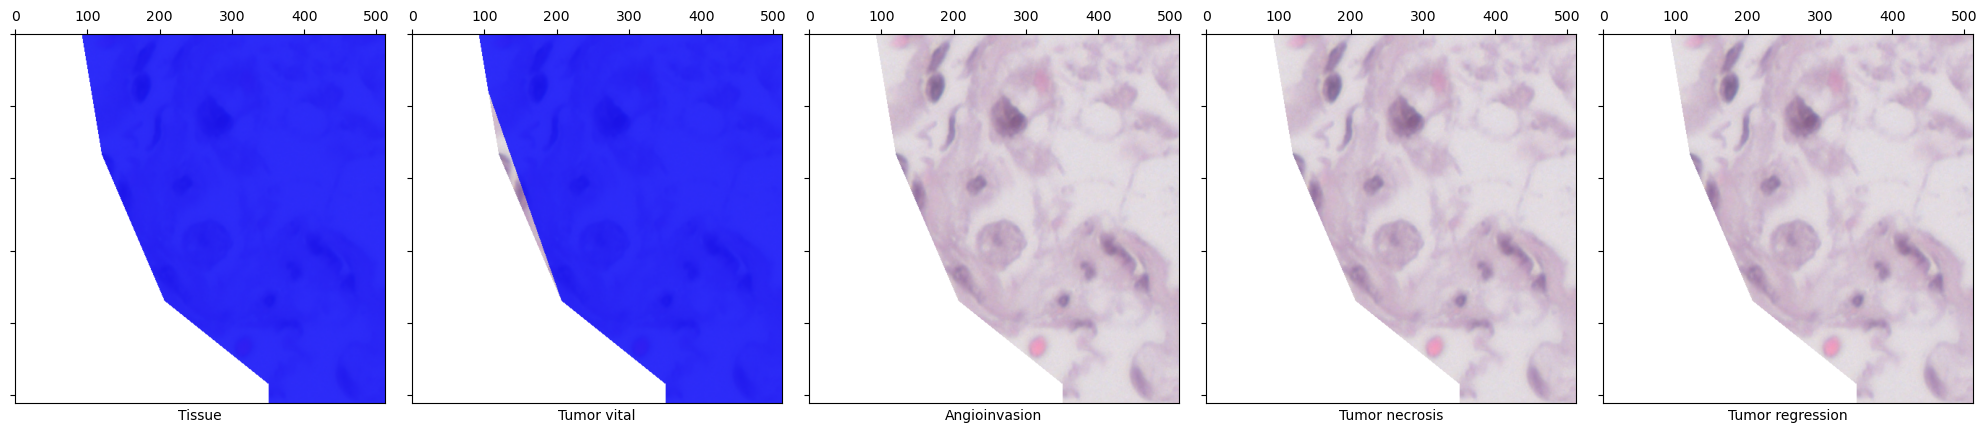

In [7]:
overlay_masks(dataset[0])

In [8]:
# plot the first image
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt
import torch
from matplotlib import colors
import matplotlib.legend_handler as lh
from matplotlib.lines import Line2D
import os
import matplotlib

def semantic_masks(sample, path=""):

    # sample = dataset[idx] #next(iter(dataloader_train))
    image, masks = sample['data'][:3], sample['data'][3:]
    # tissue, masks = masks[0], masks[1:]
    # tissue = masks[0]
    # unnormalize
    tissue = masks[0]
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    image = image * tissue
    img = (image * 255).type(torch.uint8)
    # black -> white
    img[img==0] = 255
    masks = masks.type(torch.bool)


    # Get the tab10 colormap
    tab10 = matplotlib.colormaps['tab10'].colors

    # Convert RGB to hex values
    colors_hex = [colors.rgb2hex(color) for color in tab10]
    custom_lines = [Line2D([0], [0], color=colors_hex[i], lw=4, alpha=0.6) for i in range(len(colors_hex))]

    # drawn_masks =  draw_segmentation_masks(img, masks, alpha=0.4, colors=["red", "blue", "green", "purple", "yellow", "orange", "brown"])
    drawn_masks =  draw_segmentation_masks(img, masks, alpha=0.4, colors=colors_hex)


    fig, ax = plt.subplots()
    lines = ax.imshow(torch.einsum("chw -> hwc", drawn_masks))
    ax.legend(custom_lines, [x.replace("_", " ") for x in config["annos_of_interest"]], 
    loc='best', bbox_to_anchor=(1.0, 1.21),
    ncols=2
    )
    # plt.show()
    # name=f"postproc_subimage_{sample['case_id']}-{sample['stain_id']}"
    # if path is not None and not os.path.exists(path+name+".svg"):

    #     fig.savefig(path+name+".png", dpi=600, format='png', transparent=True)
    #     fig.savefig(path+name+".svg", dpi=600, format='svg', transparent=True)

    return fig, ax

In [9]:
config: dict[str, int | str | list | float] = {
    "batch_size": 1,
    "target_level": 3,
    "num_workers": 9,
    'seed':42,
    "base_dir": "/data2/projects/DigiStrudMed_sklein/",
    "data_split": [0.8, 0.15, 0.05],
    "annos_of_interest": [
        "Tissue",
        "Tumor_vital",
        "Angioinvasion",
        "Tumor_necrosis",
        "Tumor_regression",
    ],
}

In [10]:
# import numpy as np

# # Define the grid size
# grid_size = (9, 9)

# # Create the figure and axes for the grid
# fig, axes = plt.subplots(*grid_size)

# # Iterate through the axes and plot the image on each one
# for i in range(grid_size[0]):
#     for j in range(grid_size[1]):
#         ax = axes[i][j]
#         # Call the function that returns a fig and ax object
#         img_fig, img_ax = semantic_masks(dataset[np.random.randint(0, len(dataset))])
#         # Transfer the contents of the image ax to the grid ax
#         # ax.set_title(f"Image {i+1},{j+1}")
#         ax.axis("off")
#         ax.imshow(img_ax.get_images()[0].get_array())

# # Get the tab10 colormap
# tab10 = matplotlib.colormaps['tab10'].colors

# # Convert RGB to hex values
# colors_hex = [colors.rgb2hex(color) for color in tab10]
# custom_lines = [Line2D([0], [0], color=colors_hex[i], lw=4, alpha=0.6) for i in range(len(colors_hex))]

# fig.legend(custom_lines, [x.replace("_", " ") for x in config["annos_of_interest"]], 
# loc='upper left', bbox_to_anchor=(1.0, 1.21),
# ncols=2
# )
# fig.tight_layout()
# ax.figsize=(20,20)
# plt.show()

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    return fig, axs

In [12]:
def split_and_denormalize(sample):
    image, masks = sample['data'][:3], sample['data'][3:]

    # unnormalize
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    # remove background, mask[0] == tissue
    image = image * masks[0]
    img = (image * 255).type(torch.uint8)
    # black -> white
    img[img==0] = 255
    # to bool
    masks = masks.type(torch.bool)

    return img, masks

In [13]:
def get_tab10_legend():
    # Get the tab10 colormap
    tab10 = matplotlib.colormaps['tab10'].colors

    # Convert RGB to hex values
    colors_hex = [colors.rgb2hex(color) for color in tab10]
    custom_lines = [Line2D([0], [0], color=colors_hex[i], lw=4, alpha=0.6) for i in range(len(colors_hex))]

    return custom_lines, colors_hex

In [14]:
dataset.data

[{'image': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C.svs',
  'geojson': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C.json',
  'Tumor_regression': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C-Tumor_regression.tif',
  'Tumor_vital': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C-Tumor_vital.tif',
  'Tissue': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C-Tissue.tif',
  'uncensored': 1.0,
  'surv_days': 218.0,
  'patch_size': (512, 512),
  'num_patches': 26868,
  'case_id': 1,
  'stain_id': 1,
  'location': (17312, 191263)},
 {'image': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C.svs',
  'geojson': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C.json',
  'Tumor_regression': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_B

INFO:Timer:Loading image and masks 7.867813110351562e-06
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
INFO:Timer:Loading done 0.0019540786743164062
INFO:Timer:Starting patch extraction for masks 0.0023603439331054688
INFO:Timer:Size of image patch [512, 512, 3] 0.13082027435302734
INFO:Timer:Patch extraction for image done 0.13118481636047363
INFO:Timer:Starting conversion to tensor 0.13148093223571777
INFO:Timer:Converting masks to numpy done 0.1317763328552246
INFO:Timer:Converting to tensor done 0.13329720497131348
INFO:Timer:Starting padding 0.1336355209350586
INFO:Timer:Padding done 0.13399004936218262
INFO:Timer:R

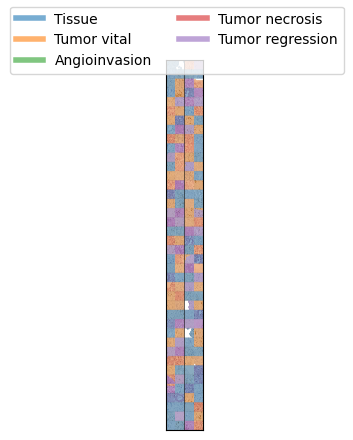

In [20]:
from torchvision.utils import make_grid
custom_lines, colors_hex = get_tab10_legend()
drawn_masks = []
size = 160, 10
for i in range(size[0]):
    img, masks = split_and_denormalize(dataset[np.random.randint(0, len(dataset))])
    drawn_masks.append(draw_segmentation_masks(img, masks, alpha=0.4, colors=colors_hex))

grid_masks = make_grid(drawn_masks, nrow=size[1])
fig, axs = show(grid_masks)
fig.legend(custom_lines, [x.replace("_", " ") for x in config["annos_of_interest"]], 
loc='upper center', #bbox_to_anchor=(1.0, 1.0),
ncols=2
)

path = "/home/sklein/"
name=f"postproc_subimage_{dataset.data[0]['case_id']}_{size}"
fig.savefig(path+name+".png", dpi=600, format='png', transparent=True)
fig.savefig(path+name+".svg", dpi=600, format='svg', transparent=True)